In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_2L = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_2L = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train_2L.shape, x_test_2L.shape)

# i want to make the images 32*32 so ill pad the data with two rows of zeros on the top
# and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

x_train_3L = np.pad(x_train_2L, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test_3L = np.pad(x_test_2L, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print(x_train_3L.shape, x_test_3L.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 32, 32, 1) (10000, 32, 32, 1)


Here i will implement a 2 layers model

Note: the pooling layer will always reduce the size of each feature map by a factor of 2. (most commonly used),

upsampling layer will increase the size of each feature map by a factor of 2. (most commonly used)(opposite of pooling layer)

* So at the input layer, the input image will be (28,28,1) and the output will be (28,28,1)
* At the first convolutional layer, the input image will be (28,28,1) and the output will be (28,28,32)
* At the first pooling layer, the input image will be (28,28,32) and the output will be (14,14,32)
* At the second convolutional layer, the input image will be (14,14,32) and the output will be (14,14,16)
* At the second pooling layer, the input image will be (14,14,16) and the output will be (7,7,16)

... then the opposite will happen to return to the original image shape

* so at the third convolutional layer, the input image will be (7,7,16) and the output will be (7,7,16)
* At the first upsampling layer, the input image will be (7,7,16) and the output will be (14,14,16)
* At the fourth convolutional layer, the input image will be (14,14,16) and the output will be (14,14,32)
* At the secound upsampling layer, the input image will be (14,14,32) and the output will be (28,28,32)
* at the last convolutional layer, the input image will be (28,28,32) and the output will be (28,28,1)  <== this is the output of the autoencoder



pooling helps to make the representation become approximately invariant to small translations of the input. Invariance to translation means that if we translate the input by a small amount, the values of most of the pooled outputs do not change.

In [4]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))


# encoding layer 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# encoding layer 2
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

#---------------------------------------------------

# decoding layer 2
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)

# decoding layer 3
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# these values are for 5 epochs and 128 batchsize

# Total params: 3,217 for  16 - 8  val 0.0760
# Total params: 7,265 for  16 - 16 val 0.0718
# Total params: 12,193 for 32 - 16 val 0.0702 <= chosen
# Total params: 28,353 for 32 - 32 val 0.068

In [5]:
# models
autoencoder_2L = keras.Model(input_img, decoded,name='AutoEncoder_2L')
encoder_2L = keras.Model(input_img, encoded,name='Encoder_2L')

encoded_img_2L = keras.Input(shape=(7,7,16))

x = autoencoder_2L.layers[-5](encoded_img_2L)
for i in range(-4,0):
    x = autoencoder_2L.layers[i](x)
decoder_2L = keras.Model(encoded_img_2L,x,name='Decoder_2L')

autoencoder_2L.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_2L.summary()
encoder_2L.summary()
decoder_2L.summary()

Model: "AutoEncoder_2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)       

In [6]:
autoencoder_2L.fit(x_train_2L, x_train_2L,
                epochs=25, #5, #50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_2L, x_test_2L))

Epoch 1/25
469/469 [==============================] - 37s 14ms/step - loss: 0.1274 - val_loss: 0.0792
Epoch 2/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0772 - val_loss: 0.0744
Epoch 3/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0741 - val_loss: 0.0724
Epoch 4/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0725 - val_loss: 0.0712
Epoch 5/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0715 - val_loss: 0.0704
Epoch 6/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0708 - val_loss: 0.0698
Epoch 7/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0702 - val_loss: 0.0693
Epoch 8/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0697 - val_loss: 0.0689
Epoch 9/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0693 - val_loss: 0.0685
Epoch 10/25
469/469 [==============================] - 6s 13ms/step - loss: 0.0689 - val_l

The implementation of the 3 layers model

Here i had 2 choices:

1. make the input shape the normal (28,28,1) and remove the padding in decoding layer 3
2. use the zero padded input ( x_train_3L ) (32,32,1) and keep the padding

i tried both however i noticed that the padded input was alot better 🤔🤔

(32)=>(16)=>(8)=> (4) =>(8)=>(16)=>(32)

In [7]:
import keras
from keras import layers

input_img = keras.Input(shape=(32, 32, 1))

# encoding layer 1
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# encoding layer 2
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# encoding layer 3
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


#---------------------------------------------------


# decoding layer 1
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)

# decoding layer 2
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

# decoding layer 3
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# these values are for 5 epochs and 128 batchsize

# Total params: 3,369 for 16-8-4   loss: 0.1002 - val_loss: 0.0976
# Total params: 4,385 for 16-8-8 loss: 0.0855 - val_loss: 0.0833
# Total params: 7,857 for 16-16-8 loss: 0.0806 - val_loss: 0.0790
# Total params: 11,905 for 16-16-16 loss: 0.0742 - val_loss: 0.0724  <= chosen
# Total params: 12,785 for 32-16-8 loss: 0.0788 - val_loss: 0.0768
# Total params: 16,833 for 32-16-16 loss: 0.0732 - val_loss: 0.0713
# Total params: 30,689 for 32-32-16 loss: 0.0684 - val_loss: 0.0666

In [8]:
# models
autoencoder_3L = keras.Model(input_img, decoded,name='AutoEncoder_3L')
encoder_3L = keras.Model(input_img, encoded,name='Encoder_3L')

encoded_img_3L = keras.Input(shape=(4,4,16))


x = autoencoder_3L.layers[-7](encoded_img_3L)
for i in range(-6,0):
    x = autoencoder_3L.layers[i](x)
decoder_3L = keras.Model(encoded_img_3L,x,name='Decoder_3L')

autoencoder_3L.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_3L.summary()
encoder_3L.summary()
decoder_3L.summary()

Model: "AutoEncoder_3L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)       

In [9]:
autoencoder_3L.fit(x_train_3L, x_train_3L,
                epochs=25, #5, #50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_3L, x_test_3L))

# these are for 1 epoch with 128 batchsize

# all relu + sigmoid with adam loss = loss: 0.1947 - val_loss: 0.1275
# all relu + sigmoid with RMSprop loss = loss: 0.1824 - val_loss: 0.1434
# all relu + sigmoid with Nadam loss = loss: 0.1932 - val_loss: 0.1452

Epoch 1/25
469/469 [==============================] - 8s 15ms/step - loss: 0.1472 - val_loss: 0.0988
Epoch 2/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0914 - val_loss: 0.0850
Epoch 3/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0828 - val_loss: 0.0796
Epoch 4/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0778 - val_loss: 0.0749
Epoch 5/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0746 - val_loss: 0.0724
Epoch 6/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0725 - val_loss: 0.0705
Epoch 7/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0709 - val_loss: 0.0696
Epoch 8/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0696 - val_loss: 0.0682
Epoch 9/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0685 - val_loss: 0.0671
Epoch 10/25
469/469 [==============================] - 7s 14ms/step - loss: 0.0676 - val_lo

In [10]:
encoded_2L = encoder_2L.predict(x_test_2L)
decoded_2L = decoder_2L.predict(encoded_2L)

encoded_3L = encoder_3L.predict(x_test_3L)
decoded_3L = decoder_3L.predict(encoded_3L)

In [11]:
print(x_test_2L.shape)
print(encoded_2L.shape)
print(decoded_2L.shape)

print("-----------------------")

print(x_test_3L.shape)
print(encoded_3L.shape)
print(decoded_3L.shape)

(10000, 28, 28, 1)
(10000, 7, 7, 16)
(10000, 28, 28, 1)
-----------------------
(10000, 32, 32, 1)
(10000, 4, 4, 16)
(10000, 32, 32, 1)


generating 10 random indices to use in plotting the samples

In [12]:
import random

noOfRandomlySelectedImages = 10  
randomIndices = random.sample(range(0,x_test.shape[0]), noOfRandomlySelectedImages)

print(randomIndices)

[5206, 3640, 9453, 8006, 3957, 520, 2722, 7366, 1272, 1733]


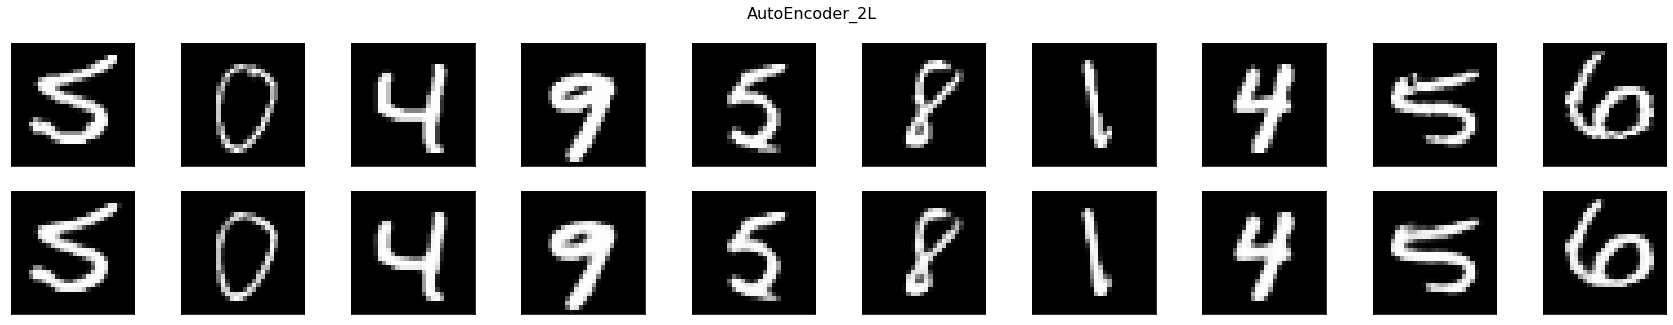

In [18]:
import matplotlib.pyplot as plt

n = noOfRandomlySelectedImages
plt.figure(figsize=(30, 5))
for i,j in zip(randomIndices,range(n)):
    # Display original
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x_test_2L[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # # Display Encoded_2L
    # ax = plt.subplot(5, n, j + 1 + n)
    # plt.imshow(encoded_2L[i])
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # Display reconstruction_2l
    ax = plt.subplot(2, n, j + 1 + (n))
    plt.imshow(decoded_2L[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("AutoEncoder_2L",fontsize=16)
plt.show()

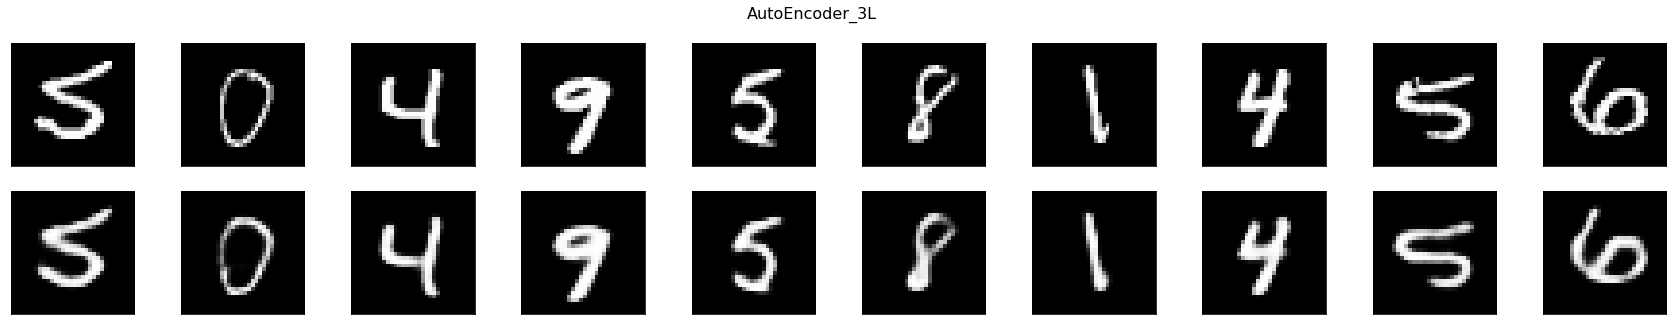

In [19]:
import matplotlib.pyplot as plt

n = noOfRandomlySelectedImages
plt.figure(figsize=(30, 5))
for i,j in zip(randomIndices,range(n)):
    # Display original
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x_test_3L[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Encoded_3L
    # ax = plt.subplot(3, n, j + 1 + n)
    # plt.imshow(encoded_3L[i])
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # Display reconstruction_3l
    ax = plt.subplot(2, n, j + 1 + (1 * n))
    plt.imshow(decoded_3L[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("AutoEncoder_3L",fontsize=16)
plt.show()